### DGM PHASE 1 — P95 TAIL (FOUNDATION)
Learn the conditional distribution of daily basin-mean rainfall given that it exceeds the 95th percentile, using bias-corrected ERA5.

In [1]:
import pandas as pd
import numpy as np

# ============================================================
# LOAD BIAS-CORRECTED ERA5 MUSI DAILY RAINFALL
# ============================================================

df = pd.read_parquet(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "era5_musi_bias_corrected_daily.parquet"
)

df["valid_time"] = pd.to_datetime(df["valid_time"])

rain = df["era5_mm_bc"].values

# ============================================================
# COMPUTE P95 THRESHOLD
# ============================================================

p95 = np.percentile(rain, 95)

print(f"P95 rainfall threshold: {p95:.2f} mm")

# ============================================================
# EXTRACT TAIL
# ============================================================

tail = rain[rain > p95]

print("Total days:", len(rain))
print("Tail samples (P95+):", len(tail))
print("Tail fraction:", len(tail) / len(rain))

# ============================================================
# BASIC SANITY
# ============================================================

print("\nTail statistics:")
print(pd.Series(tail).describe())

# ============================================================
# SAVE FOR DGM
# ============================================================

out_path = (
    "/vol/sandeep_storage/Files2/catastrophe/"
    "rainfall_tail_p95.npy"
)

np.save(out_path, tail)

print("\nSaved P95 tail array to:")
print(out_path)


P95 rainfall threshold: 14.66 mm
Total days: 5113
Tail samples (P95+): 256
Tail fraction: 0.0500684529630354

Tail statistics:
count    256.000000
mean      27.074979
std       13.518327
min       14.670618
25%       17.639906
50%       22.776121
75%       32.475358
max      106.115243
dtype: float64

Saved P95 tail array to:
/vol/sandeep_storage/Files2/catastrophe/rainfall_tail_p95.npy


#### DGM PHASE 1.1 — Tail Transformation & Diagnostics 
Transform the P95 tail into a stable learning variable and verify it behaves well enough for a generative model.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ============================================================
# LOAD P95 TAIL
# ============================================================

tail = np.load(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "rainfall_tail_p95.npy"
)

P95 = 14.66  # from your computed value

# ============================================================
# LOG-EXCESS TRANSFORMATION
# ============================================================

excess = tail - P95
assert np.all(excess > 0), "Non-positive excess detected!"

log_excess = np.log(excess)

print("Log-excess stats:")
print(pd.Series(log_excess).describe())

# ============================================================
# SAVE FOR DGM
# ============================================================

out_path = (
    "/vol/sandeep_storage/Files2/catastrophe/"
    "rainfall_log_excess_p95.npy"
)

np.save(out_path, log_excess)

print("\nSaved log-excess tail to:")
print(out_path)


Log-excess stats:
count    256.000000
mean       1.801590
std        1.502220
min       -4.545214
25%        1.091890
50%        2.093837
75%        2.880061
max        4.515850
dtype: float64

Saved log-excess tail to:
/vol/sandeep_storage/Files2/catastrophe/rainfall_log_excess_p95.npy


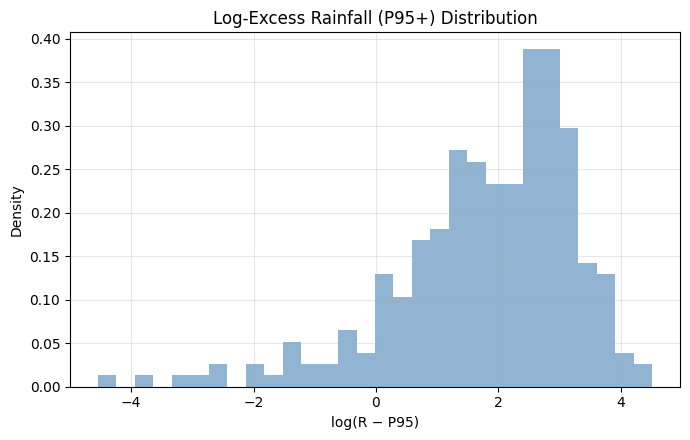

In [3]:
plt.figure(figsize=(7, 4.5))
plt.hist(log_excess, bins=30, density=True, alpha=0.6, color="steelblue")
plt.title("Log-Excess Rainfall (P95+) Distribution")
plt.xlabel("log(R − P95)")
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


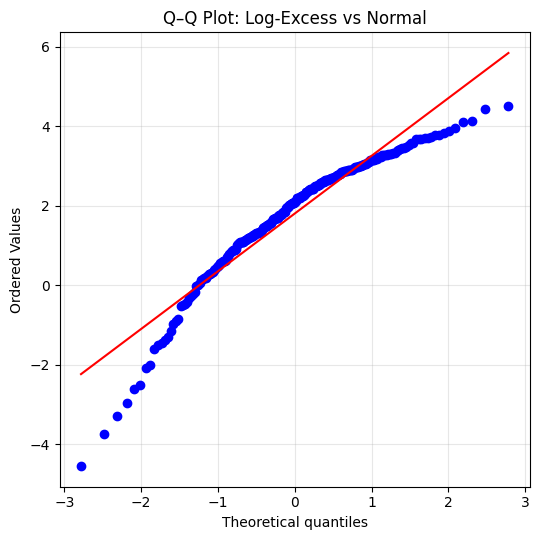

In [4]:
plt.figure(figsize=(5.5, 5.5))
stats.probplot(log_excess, dist="norm", plot=plt)
plt.title("Q–Q Plot: Log-Excess vs Normal")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [5]:
print("Skewness:", stats.skew(log_excess))
print("Kurtosis:", stats.kurtosis(log_excess))


Skewness: -1.23633825645796
Kurtosis: 2.0688550617952934


#### DGM PHASE 2 — VAE FOR RAINFALL TAIL ENRICHMENT (P95+)

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# ============================================================
# LOAD DATA
# ============================================================

data = np.load(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "rainfall_log_excess_p95.npy"
)

x = torch.tensor(data, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(x)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# ============================================================
# VAE MODEL
# ============================================================

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )

        self.mu_z = nn.Linear(8, 1)
        self.logvar_z = nn.Linear(8, 1)

        # Decoder
        self.dec = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU()
        )

        self.mu_x = nn.Linear(16, 1)
        self.logvar_x = nn.Linear(16, 1)

    def encode(self, x):
        h = self.enc(x)
        return self.mu_z(h), self.logvar_z(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.dec(z)
        return self.mu_x(h), self.logvar_x(h)

    def forward(self, x):
        mu_z, logvar_z = self.encode(x)
        z = self.reparameterize(mu_z, logvar_z)
        mu_x, logvar_x = self.decode(z)
        return mu_x, logvar_x, mu_z, logvar_z


# ============================================================
# LOSS FUNCTION (ELBO)
# ============================================================

def vae_loss(x, mu_x, logvar_x, mu_z, logvar_z):
    recon = 0.5 * (
        logvar_x + (x - mu_x)**2 / torch.exp(logvar_x)
    ).mean()

    kl = -0.5 * torch.mean(
        1 + logvar_z - mu_z**2 - torch.exp(logvar_z)
    )

    return recon + kl


# ============================================================
# TRAINING
# ============================================================

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

N_EPOCHS = 1500

for epoch in range(N_EPOCHS):
    total_loss = 0.0
    for (batch,) in loader:
        optimizer.zero_grad()
        mu_x, logvar_x, mu_z, logvar_z = model(batch)
        loss = vae_loss(batch, mu_x, logvar_x, mu_z, logvar_z)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Loss: {total_loss:.4f}")

# ============================================================
# SAVE MODEL
# ============================================================

torch.save(
    model.state_dict(),
    "/vol/sandeep_storage/Files2/catastrophe/"
    "vae_log_excess_p95.pt"
)

print("VAE training complete and saved.")


Epoch    0 | Loss: 13.8288
Epoch  200 | Loss: 6.0435
Epoch  400 | Loss: 6.4189
Epoch  600 | Loss: 5.7067
Epoch  800 | Loss: 6.2926
Epoch 1000 | Loss: 5.9464
Epoch 1200 | Loss: 6.2792
Epoch 1400 | Loss: 6.3561
VAE training complete and saved.


#### DGM PHASE 3 — VAE TAIL SAMPLING & RAINFALL RECONSTRUCTION

In [7]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ============================================================
# CONSTANTS
# ============================================================

P95 = 14.66  # mm
N_SAMPLES = 10000

MODEL_PATH = (
    "/vol/sandeep_storage/Files2/catastrophe/"
    "vae_log_excess_p95.pt"
)

# ============================================================
# DEFINE VAE ARCHITECTURE (MUST MATCH TRAINING)
# ============================================================

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )

        self.mu_z = nn.Linear(8, 1)
        self.logvar_z = nn.Linear(8, 1)

        self.dec = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU()
        )

        self.mu_x = nn.Linear(16, 1)
        self.logvar_x = nn.Linear(16, 1)

    def decode(self, z):
        h = self.dec(z)
        return self.mu_x(h), self.logvar_x(h)


# ============================================================
# LOAD TRAINED MODEL
# ============================================================

model = VAE()
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

print("VAE loaded successfully")

# ============================================================
# SAMPLE LATENT SPACE
# ============================================================

z = torch.randn(N_SAMPLES, 1)

with torch.no_grad():
    mu_x, logvar_x = model.decode(z)
    std_x = torch.exp(0.5 * logvar_x)
    log_excess_samples = mu_x + std_x * torch.randn_like(std_x)

log_excess_samples = log_excess_samples.squeeze().numpy()

# ============================================================
# BACK-TRANSFORM TO RAINFALL (mm)
# ============================================================

rainfall_samples = P95 + np.exp(log_excess_samples)

# Remove pathological values (safety)
rainfall_samples = rainfall_samples[
    np.isfinite(rainfall_samples) & (rainfall_samples > P95)
]

print("Generated rainfall samples:", len(rainfall_samples))
print("Rainfall stats (mm):")
print(
    f"Min={rainfall_samples.min():.2f}, "
    f"Median={np.median(rainfall_samples):.2f}, "
    f"Mean={rainfall_samples.mean():.2f}, "
    f"Max={rainfall_samples.max():.2f}"
)

# ============================================================
# SAVE FOR MONTE CARLO INJECTION
# ============================================================

out_path = (
    "/vol/sandeep_storage/Files2/catastrophe/"
    "rainfall_tail_vae_p95.npy"
)

np.save(out_path, rainfall_samples)
print("Saved VAE rainfall tail samples to:")
print(out_path)


VAE loaded successfully
Generated rainfall samples: 10000
Rainfall stats (mm):
Min=14.66, Median=22.66, Mean=27.21, Max=201.63
Saved VAE rainfall tail samples to:
/vol/sandeep_storage/Files2/catastrophe/rainfall_tail_vae_p95.npy


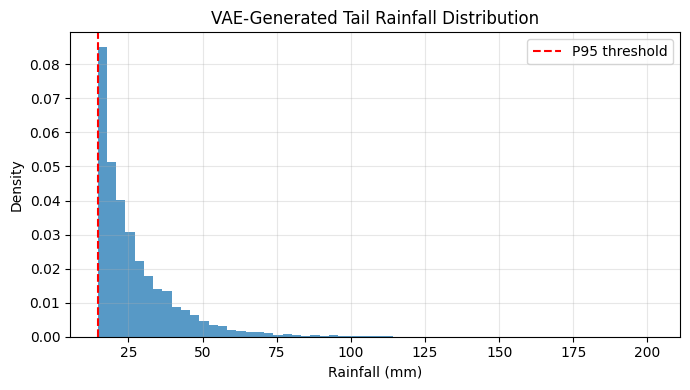

In [8]:
plt.figure(figsize=(7, 4))
plt.hist(rainfall_samples, bins=60, density=True, alpha=0.75)
plt.axvline(P95, color="red", linestyle="--", label="P95 threshold")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Density")
plt.title("VAE-Generated Tail Rainfall Distribution")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


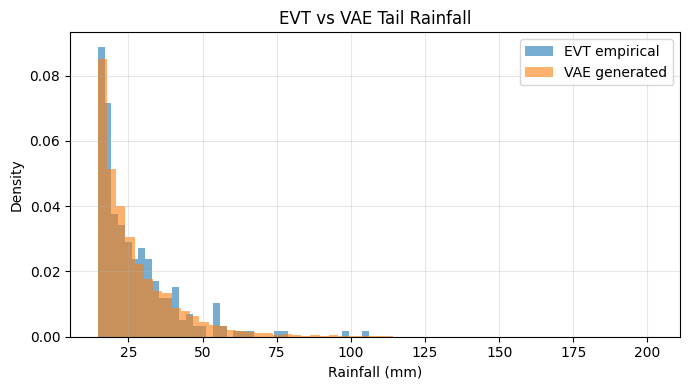

In [9]:
evt_tail = np.load(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "rainfall_tail_p95.npy"
)

plt.figure(figsize=(7, 4))
plt.hist(evt_tail, bins=40, density=True, alpha=0.6, label="EVT empirical")
plt.hist(rainfall_samples, bins=60, density=True, alpha=0.6, label="VAE generated")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Density")
plt.title("EVT vs VAE Tail Rainfall")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#### DGM PHASE 4 — LOSS ENGINE INJECTION

In [10]:
import numpy as np
import geopandas as gpd
from scipy.stats import genextreme

# ----------------------------
# Load trained VAE tail output
# ----------------------------
vae_tail = np.load(
    "/vol/sandeep_storage/Files2/catastrophe/rainfall_tail_vae_p95.npy"
)

P95 = 14.66  # already computed


In [11]:
MU = 48.47
SIGMA = 15.35
XI = 0.094
SHAPE = -XI   # scipy convention

R100 = 136.87


In [12]:
waste = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_damage_scenarios_evt.geojson"
)

ASSET_VALUE = {
    "wastewater_plant": 5e7,
    "landfill": 2e7,
    "transfer_station": 1.5e7,
    "recycling": 1e7,
    "other": 1e7
}
DEFAULT_VALUE = 1e7


In [13]:
LAMBDA_EVENTS = 0.4
N_YEARS = 10000
TAIL_PROB = 0.05   # P95+

annual_losses_vae = []

for _ in range(N_YEARS):

    n_events = np.random.poisson(LAMBDA_EVENTS)
    year_loss = 0.0

    for _ in range(n_events):

        # Decide if tail event
        if np.random.rand() < TAIL_PROB:
            rainfall = np.random.choice(vae_tail)
        else:
            rainfall = genextreme.rvs(
                SHAPE, loc=MU, scale=SIGMA
            )

        if rainfall <= 0:
            continue

        event_hazard = min(rainfall / R100, 1.0)

        for _, row in waste.iterrows():

            asset = ASSET_VALUE.get(
                row["facility_type"], DEFAULT_VALUE
            )

            facility_hazard = min(
                row["flood_hazard_index"] * event_hazard, 1.0
            )

            damage_ratio = min(facility_hazard ** 1.5, 1.0)

            year_loss += asset * damage_ratio

    annual_losses_vae.append(year_loss)

annual_losses_vae = np.array(annual_losses_vae)


In [14]:
loss_sorted_vae = np.sort(annual_losses_vae)[::-1]
ep_vae = np.arange(1, len(loss_sorted_vae) + 1) / (len(loss_sorted_vae) + 1)

AAL_VAE = annual_losses_vae.mean()

print(f"VAE-Injected AAL: {AAL_VAE:,.2f}")


VAE-Injected AAL: 31,712,426.37


In [15]:
target_eps = [0.10, 0.05, 0.02, 0.01]

vae_pml = {
    p: np.percentile(annual_losses_vae, 100 * (1 - p))
    for p in target_eps
}

for p, l in vae_pml.items():
    print(f"VAE EP={int(p*100)}% → Loss = {l/1e6:.0f} M")


VAE EP=10% → Loss = 110 M
VAE EP=5% → Loss = 158 M
VAE EP=2% → Loss = 222 M
VAE EP=1% → Loss = 280 M


In [16]:
np.save(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "annual_losses_vae_injected.npy",
    annual_losses_vae
)


In [19]:
annual_losses_vae = np.load(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "annual_losses_vae_injected.npy"
)


----